In [1]:
%matplotlib inline 
import pandas as pd
import numpy as np
import collections
import xarray as xr
import dask.array as da
import os
import glob
import time
from scipy import stats
import matplotlib as mpl
import matplotlib.pyplot as plt
# from statsmodels.distributions.empirical_distribution import ECDF

import seaborn as sns
sns.set_style('white')
sns.set_context("talk") #[poster, paper, talk, notebook]

import warnings; warnings.simplefilter('ignore') #not the best, but helps when zeros are out of hand
#degree sign... ($^{\circ}$C)

### functions

In [2]:
def ecdf(data):
    '''Computes Empirical CDF'''
    data = data.flatten()
    x = np.sort(data.flatten())
    f = np.arange(1, len(x)+1)/(len(x))
    return x, f

# real data
*NOTE: 
- data subregions, cm
- 20m dataset, mm

In [3]:
# fname = '~/Documents/research/sierra/data/compiled_SUPERsnow_3km_subregion.nc' #BSU
fname = '~/Documents/research/sierra/data/20m_analysis/compiled_SUPERsnow_20m.nc' 
ds = xr.open_dataset(fname,  chunks={'time':1,'x':1000,'y':1000})
ds['snow'] = ds.snow.where(ds.mask==1) #all snow inside the basin
ds['snow'] = ds.snow.where(ds.dem>=2000) #all snow at 2000m elev and above (~6500ft)
ds['snow'] = ds.snow.where(ds.snow>=0) #all snow >= zero
ds['snow'] = ds.snow/10 #to cm
ds.x.attrs['long_name']='Easting'; ds.x.attrs['units']='m'
ds.y.attrs['long_name']='Northing'; ds.y.attrs['units']='m'
ds=ds.astype(np.float32, copy=False)
ds.close()
ds

<xarray.Dataset>
Dimensions:  (time: 51, x: 2637, y: 2739)
Coordinates:
  * x        (x) float32 254000.0 254020.0 254040.0 ... 306700.0 306720.0
  * y        (y) float32 4234060.0 4234040.0 4234020.0 ... 4179320.0 4179300.0
  * time     (time) datetime64[ns] 2013-04-03 2013-04-29 ... 2018-05-28
    mask     (y, x) uint8 dask.array<chunksize=(1000, 1000), meta=np.ndarray>
    dem      (y, x) float32 dask.array<chunksize=(1000, 1000), meta=np.ndarray>
    veg      (y, x) float32 dask.array<chunksize=(1000, 1000), meta=np.ndarray>
Data variables:
    snow     (time, y, x) float32 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>

#### compute and sort by SCA
- change the perc_coverage to set the limit of SCA you want
- returns: # of ALS with __% SCA

In [4]:
# perc_coverage = 80 #lower limit of SCA that will be kept

# # Number of pixels in basin mask (but really, number of pix at elevations > 2000m)
# unique, counts = np.unique(ds.dem>=2000, return_counts=True)
# dict(zip(unique, counts)) #unique= 0 (outside basin), 1 (inside basin), counts= # of 0s, # of 1s

# # number of pixels >0 in ALS
# c = ds.snow.where(ds.snow>0).count(dim=('x', 'y'))

# sca = c/counts[1] * 100

# sca_list = list(zip(ds.time.values, sca.values))

# sca_df = pd.DataFrame(sca_list, columns = ['Date', '% SCA'])
# sca_df_filt = sca_df[sca_df['% SCA'] >= perc_coverage]

# print('{} ALS with {}% snow covered area'.format(len(sca_df_filt), perc_coverage))

# ix_lst = list(sca_df_filt.index) #index list to filter ds dates !!
# print(counts[1])

#### apply SCA filter to DataSet

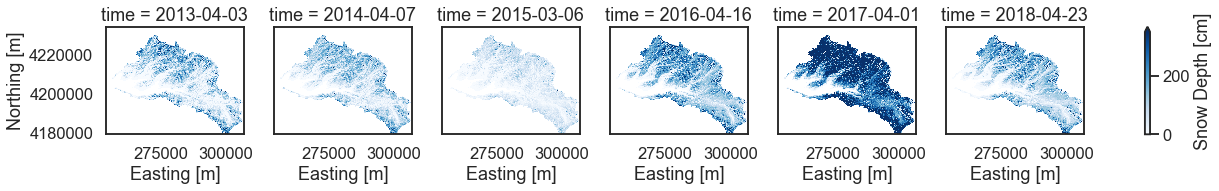

In [4]:
# ds = ds.isel(time=ix_lst)
ds = ds.isel(time=[0,7,18,30,42,49])
#quick plot check
ds.snow.plot.imshow(x='x', y='y', col='time', col_wrap=6, cmap='Blues', vmax=350, cbar_kwargs={'label': 'Snow Depth [cm]'})

In [8]:
for t in range(6):
    print(colors[t])

lightseagreen
slateblue
darkred
darkgoldenrod
chocolate
forestgreen


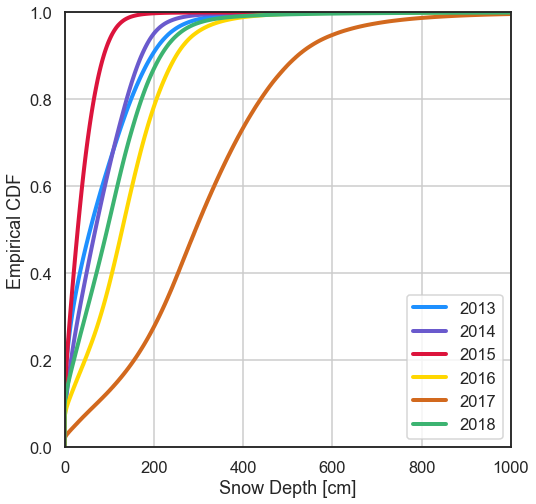

In [12]:
# Empiricial CFD Plot and compute interp ECDF map
ecdf_holder = np.zeros((len(ds.time), len(ds.y), len(ds.x)))
colors = ['dodgerblue', 'slateblue', 'crimson', 'gold', 'chocolate', 'mediumseagreen']
plt.figure(figsize=(8,8))

for t in range(len(ds.time)):

    #data
    d = ds.snow[t].values #ndarray
    ix = ~np.isnan(d)
    l = ds['time.year'].values[t]
    
    # emperical CDF
    x, f = ecdf(d[ix])

    #interpolate ecdf function
    dm = np.interp(d, x, f)
    #add to xarray
    ecdf_holder[t,:,:] = dm
    
#     plt.subplot(5,6,t+1)

#     plt.plot(x, f, color='k', linewidth=4, label=l)
    plt.plot(x, f, color=colors[t], linewidth=4, label=l)
#     plt.legend(loc='lower center')
plt.xlim(0,1000)
plt.ylim(0,1)
plt.xlabel('Snow Depth [cm]'); plt.ylabel('Empirical CDF')
plt.grid()
plt.legend(loc='lower right')
# plt.savefig('../figs/TB_21at80sca_ecdf.png', dpi=300)
# plt.tight_layout()
# plt.savefig('../figs/TB_peak_ecdf.png', dpi=300)#, transparent=True
plt.savefig('../figs/TB_peak_color_ecdf.png', dpi=300)#, transparent=True

#ADD VARIABLE TO XARRAY DATASET
ds['ecdf_snow'] = (('time', 'y','x'), da.from_array(ecdf_holder, chunks=(1, 1000, 1000)))

In [7]:
#one big ol CDF plot :)


In [8]:
# #PDFs
# plt.subplots(1, 6, figsize=(30,5))

# for t in range(len(ds.time)):

#     #data
#     d = ds.snow[t].values #ndarray
#     ix = ~np.isnan(d)
#     l = ds['time.year'].values[t]
#     plt.subplot(1,6,t+1)
#     plt.hist(d[ix], bins=np.arange(np.min(d[ix]),np.max(d[ix]),25), density=True, color='g')
#     plt.xlabel('Snow Depth [cm]'); plt.ylabel('PDF')
#     plt.xlim(-1,1000)
#     plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
#     plt.grid()
# #     plt.tight_layout()
# #     plt.savefig('../figs/TB-{}_peak_pdf_ecdf.png'.format(l), dpi=300)
# plt.tight_layout()


In [9]:
# # raw snow depth plot
# # ds['time'] = ds['time'].dt.strftime('%d-%b-%Y')
# ds.snow.plot.imshow(x='x', y='y', col='time', col_wrap=6, cmap='Blues', vmax=350, cbar_kwargs={'label': 'Snow Depth [cm]'}, figsize=(30,5))
# # plt.savefig('../figs/TB_peak_sdRaw.png', dpi=300)#, transparent=True

In [10]:
# ds.ecdf_snow.plot.imshow(x='x', y='y', col='time', col_wrap=6, cmap='coolwarm_r', vmax=1, cbar_kwargs={'label': 'ECDF value'})
# # plt.savefig('../figs/TB_peak_ecdfMap.png', dpi=300)

### further analysis

In [11]:
ds

<xarray.Dataset>
Dimensions:    (time: 6, x: 2637, y: 2739)
Coordinates:
  * x          (x) float32 254000.0 254020.0 254040.0 ... 306700.0 306720.0
  * y          (y) float32 4234060.0 4234040.0 4234020.0 ... 4179320.0 4179300.0
  * time       (time) datetime64[ns] 2013-04-03 2014-04-07 ... 2018-04-23
    mask       (y, x) uint8 dask.array<chunksize=(1000, 1000), meta=np.ndarray>
    dem        (y, x) float32 dask.array<chunksize=(1000, 1000), meta=np.ndarray>
    veg        (y, x) float32 dask.array<chunksize=(1000, 1000), meta=np.ndarray>
Data variables:
    snow       (time, y, x) float32 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    ecdf_snow  (time, y, x) float64 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>

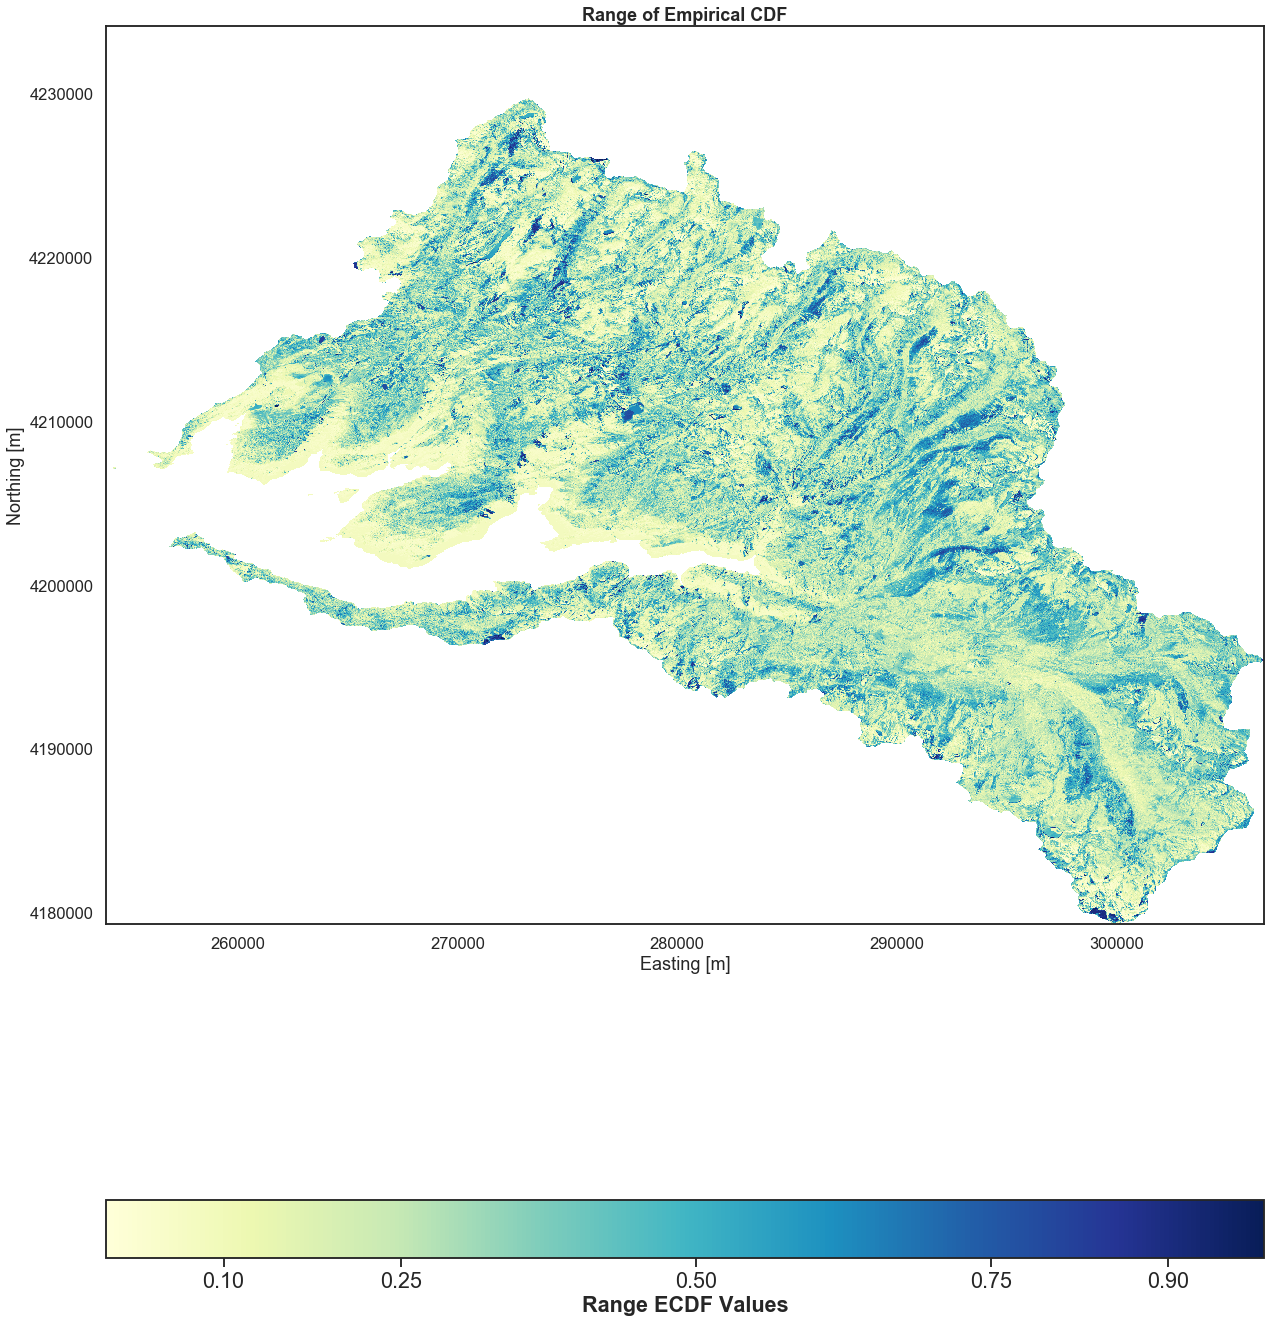

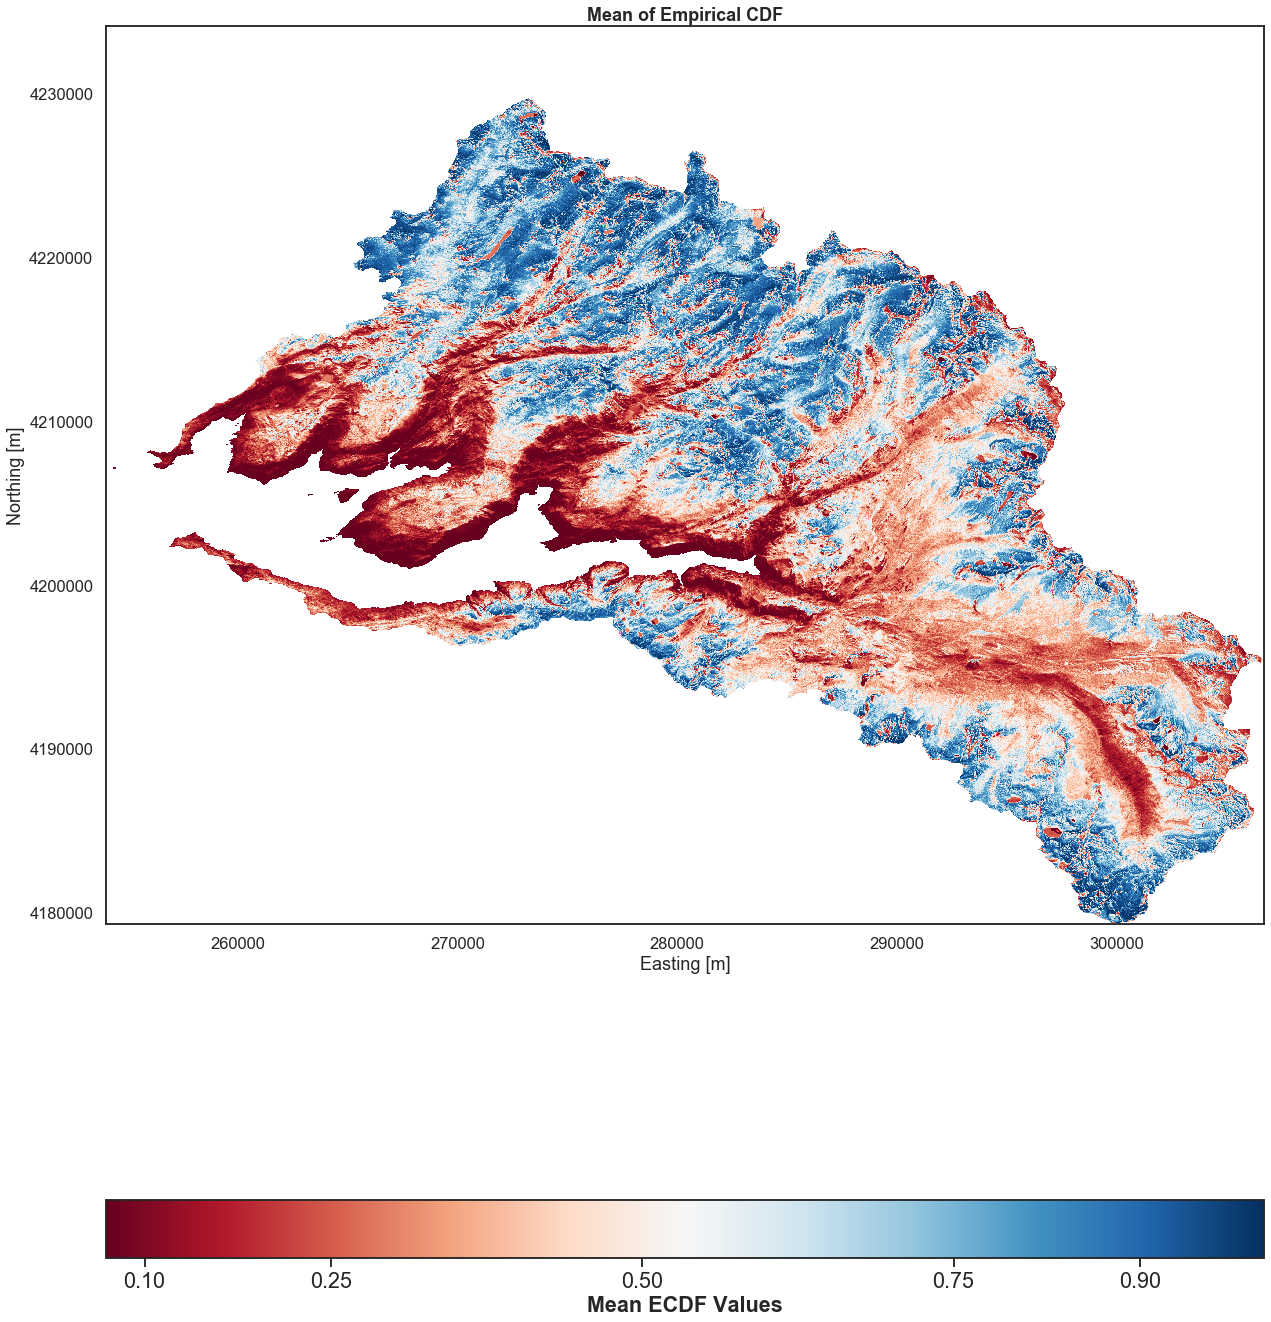

In [31]:
mx = ds.ecdf_snow.max(dim='time')
mn = ds.ecdf_snow.min(dim='time')
rn = mx - mn
plt.figure(figsize=(18,20))
im = rn.plot.imshow(cmap='YlGnBu', add_colorbar=False); plt.title('Range of Empirical CDF', weight='bold')
cb = plt.colorbar(im, ticks = [0.1, 0.25, 0.5, 0.75, 0.9], orientation="horizontal", pad=0.2)
cb.set_label(label='Range ECDF Values', size='large', weight='bold')
cb.ax.tick_params(labelsize='large')
plt.tight_layout()
plt.savefig('../figs/TB_peak_range_ecdf.png', dpi=300)
# plt.savefig('../figs/TB_21at80sca_range_ecdf.png', dpi=300)

mu = ds.ecdf_snow.mean(dim='time')
plt.figure(figsize=(18,20))
im = mu.plot.imshow( cmap='RdBu', add_colorbar=False); plt.title('Mean of Empirical CDF', weight='bold')
cb = plt.colorbar(im, ticks = [0.1, 0.25, 0.5, 0.75, 0.9], orientation="horizontal", pad=0.2)
cb.set_label(label='Mean ECDF Values', size='large', weight='bold')
cb.ax.tick_params(labelsize='large')
plt.tight_layout()
plt.savefig('../figs/TB_peak_mean_ecdf.png', dpi=300)
# plt.savefig('../figs/TB_21at80sca_mean_ecdf.png', dpi=300)

In [13]:
# from matplotlib import colors 
# newcmap = colors.ListedColormap(['indianred','white', 'navy'])
# bounds=[0, 0.5, 1] #np.linspace(-3,3,1)
# norm = colors.BoundaryNorm(bounds, newcmap.N)

In [14]:
# mu.plot.imshow(figsize=(35,30), cmap=newcmap, vmin=0, vmax=1); plt.title('Mean of CDF')

In [15]:
mu_foo = mu.to_netcdf('/Users/meganmason491/Documents/research/sierra/analysis/results/tmp/TB_peak_mean_ecdf.nc')
# mu_foo = mu.to_netcdf('/Users/meganmason491/Documents/research/sierra/analysis/results/tmp/TB_21at80sca_mean_ecdf.nc')

In [16]:
rn_foo = rn.to_netcdf('/Users/meganmason491/Documents/research/sierra/analysis/results/tmp/TB_peak_range_ecdf.nc')
# rn_foo = rn.to_netcdf('/Users/meganmason491/Documents/research/sierra/analysis/results/tmp/TB_21at80sca_range_ecdf.nc')

#### terrain stats

In [32]:
#load terrain
#20 meter
fname = '~/Documents/research/sierra/data/20m_analysis/terrain.nc' #BSU
ts = xr.open_dataset(fname,  chunks={'x':1000,'y':1000})#.drop(('dem','veg'))
#customize names
ts.x.attrs['long_name']='Easting'; ts.x.attrs['units']='m'
ts.y.attrs['long_name']='Northing'; ts.y.attrs['units']='m'
ts.aspect.attrs['long_name'] = 'Aspect'; ts.aspect.attrs['unit']='degrees'
ts.slope.attrs['long_name'] = 'Slope'; ts.slope.attrs['unit']='degrees'
ts.close()
ts
#3 meter
#...fill in here for acker...

<xarray.Dataset>
Dimensions:    (x: 2637, y: 2739)
Coordinates:
  * y          (y) float64 4.179e+06 4.179e+06 4.179e+06 ... 4.234e+06 4.234e+06
  * x          (x) float64 2.54e+05 2.54e+05 2.54e+05 ... 3.067e+05 3.067e+05
    mask       (y, x) uint8 dask.array<chunksize=(1000, 1000), meta=np.ndarray>
    dem        (y, x) float32 dask.array<chunksize=(1000, 1000), meta=np.ndarray>
    veg        (y, x) float32 dask.array<chunksize=(1000, 1000), meta=np.ndarray>
Data variables:
    aspect     (y, x) float32 dask.array<chunksize=(1000, 1000), meta=np.ndarray>
    hillshade  (y, x) float32 dask.array<chunksize=(1000, 1000), meta=np.ndarray>
    slope      (y, x) float32 dask.array<chunksize=(1000, 1000), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.5
    GDAL:         GDAL 3.0.2, released 2019/10/28
    history:      Mon Apr  6 15:30:27 2020: ncrename -v Band1,aspect aspect.n...
    NCO:          netCDF Operators version 4.8.1 (Homepage = http://nco.sf.ne...

In [18]:
# terrain variables > 2000m (to match analysis above)
msk_ = ds.mask.where(ds.dem>=2000)
elv_ = ds.dem.where(ds.dem>=2000) #ds and ts should be same here...but being consistant with ds
asp_ = ts.aspect.where(ds.dem>=2000)
slp_ = ts.slope.where(ds.dem>=2000)
veg_ = ds.veg.where(ds.dem>=2000) #ds and ts should be same here...but being consistant with ds

In [19]:
#flatten variables from - 1:ds, 2:ts, 3:ecdf
msk = msk_.values.flatten() 
elv = elv_.values.flatten()
asp = asp_.values.flatten()
slp = slp_.values.flatten()
veg = veg_.values.flatten()
muf = mu.values.flatten() 
rnf = rn.values.flatten()

In [20]:
#dataframe
d = {'elv': elv, 'asp': asp, 'slp': slp, 'veg': veg, 'mean_ecdf': muf, 'range_ecdf': rnf}                 #data to be put in df
df_ = pd.DataFrame(d)                                                                                     #create df
df = df_.dropna()                                                                                         #remove all rows with any NaN's
df.drop(df[df['asp'] < 0].index, inplace=True)
df.drop(df[df['slp'] > 60].index, inplace=True)

In [21]:
len(df)

1526077

In [33]:
df.head()

,elv,asp,slp,veg,mean_ecdf,range_ecdf
1718351,3050.661133,279.616394,2.008848,0.0,0.816415,0.150301
1718352,3051.072754,287.229889,2.905363,0.0,0.829689,0.116246
1718353,3052.319824,286.700226,3.931842,0.0,0.840736,0.094410
1718354,3054.712158,291.186890,3.501294,0.0,0.838172,0.098295
1720987,3048.983643,287.650146,0.581278,0.0,0.774529,0.184289


#### make some plots!

In [23]:
import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 1000000
# sns.axes_style({'xtick.bottom': True,
# 'xtick.top': True,
# 'ytick.left': True,
# 'ytick.right': True,})

In [24]:
# # df.plot.scatter(x='elv', y='mean_ecdf', colormap='viridis')

# df.plot.hexbin(x='slp', y='mean_ecdf', cmap='Purples', mincnt=1, vmax=500, figsize=(12,8))


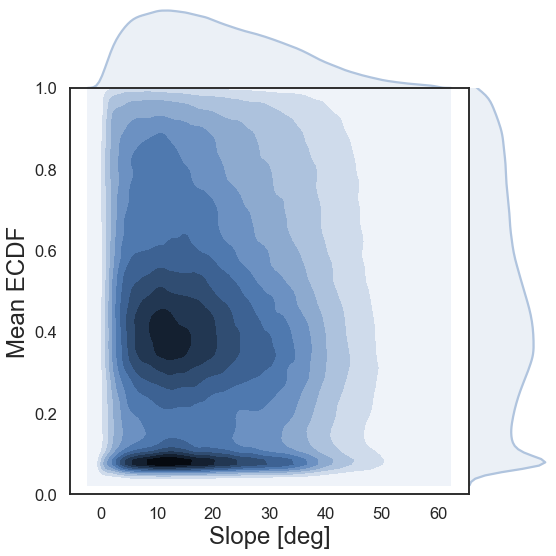

In [34]:
# #~~MEAN of ECDF~~

# #elevation
# h = sns.jointplot("elv", "mean_ecdf", data=df, kind="kde", space=0, height=8, color="lightsteelblue", ylim=(0,1)) 
# h.set_axis_labels('Elevation [m]', 'Mean ECDF', fontsize=24)
# h.savefig('../figs/TB_peak_mean_ecdf_elv.png', dpi=300)
# # h.savefig('../figs/TB_21at80sca_mean_ecdf_elv.png', dpi=300)
# #aspect
# h = sns.jointplot("asp", "mean_ecdf", data=df, kind="kde", space=0, height=8, color="lightsteelblue", ylim=(0,1))  
# h.set_axis_labels('Aspect [deg]', 'Mean ECDF', fontsize=24)
# h.savefig('../figs/TB_peak_mean_ecdf_asp.png', dpi=300)
# # h.savefig('../figs/TB_21at80sca_mean_ecdf_asp.png', dpi=300)
# #slope
h = sns.jointplot("slp", "mean_ecdf", data=df, kind="kde", space=0, height=8, color="lightsteelblue", ylim=(0,1))
h.set_axis_labels('Slope [deg]', 'Mean ECDF', fontsize=24)
h.savefig('../figs/TB_peak_mean_ecdf_slp.png', dpi=300)
# h.savefig('../figs/TB_21at80sca_mean_ecdf_slp.png', dpi=300)


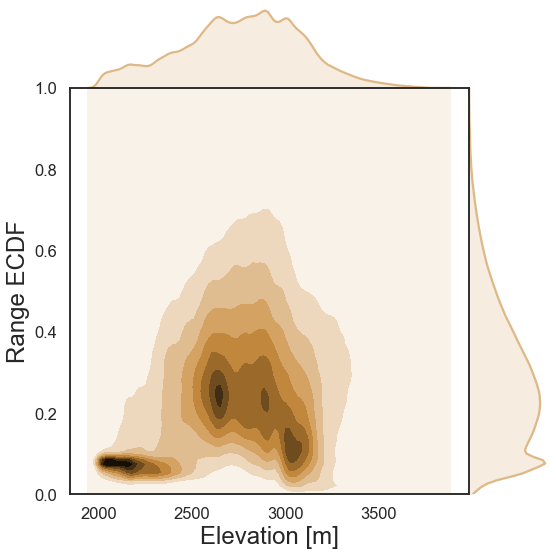

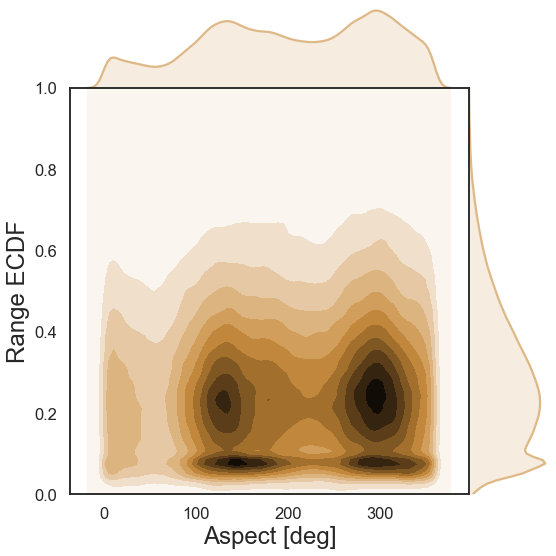

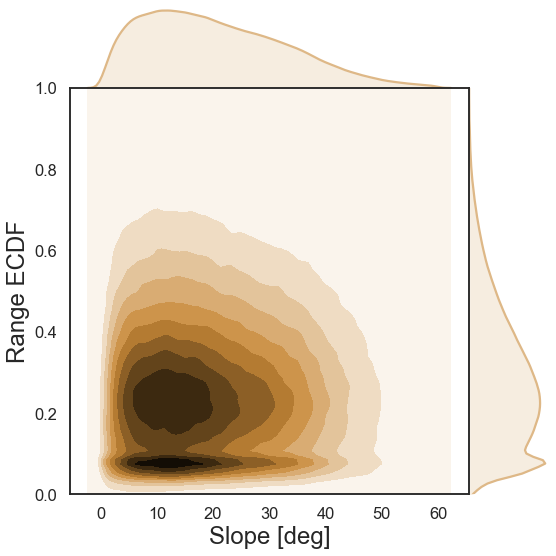

In [35]:
#~~RANGE of ECDF~~

#elevation
h = sns.jointplot("elv", "range_ecdf", data=df, kind="kde", space=0, height=8, color="burlywood", ylim=(0,1))
h.set_axis_labels('Elevation [m]', 'Range ECDF', fontsize=24)
h.savefig('../figs/TB_peak_range_ecdf_elv.png', dpi=300)
# h.savefig('../figs/TB_21at80sca_range_ecdf_elv.png', dpi=300)
#aspect
h = sns.jointplot("asp", "range_ecdf", data=df, kind="kde", space=0, height=8, color="burlywood", ylim=(0,1))
h.set_axis_labels('Aspect [deg]', 'Range ECDF', fontsize=24)
h.savefig('../figs/TB_peak_range_ecdf_asp.png', dpi=300)
# h.savefig('../figs/TB_21at80sca_range_ecdf_asp.png', dpi=300)
#slope
h = sns.jointplot("slp", "range_ecdf", data=df, kind="kde", space=0, height=8, color="burlywood", ylim=(0,1))
h.set_axis_labels('Slope [deg]', 'Range ECDF', fontsize=24)
h.savefig('../figs/TB_peak_range_ecdf_slp.png', dpi=300)
# h.savefig('../figs/TB_21at80sca_range_ecdf_slp.png', dpi=300)

#### prep for RFC

In [ ]:
# #which color?
# mu.plot.imshow(figsize=(15,10), cmap='bwr_r'); plt.title('Mean of CDF')
# mu.plot.imshow(figsize=(15,10), cmap='RdBu'); plt.title('Mean of CDF')
# mu.plot.imshow(figsize=(15,10), cmap='coolwarm_r'); plt.title('Mean of CDF')

In [29]:
#ghetto af..... :/ (getting same size to run RFC)
r_flat = rn.values.flatten()
r_flat = r_flat[-7220106:] 
m_flat = mu.values.flatten()
m_flat = m_flat[-7220106:] 

In [30]:
#save .npy for rfc
np.save('/Users/meganmason491/Documents/research/sierra/analysis/results/output/range_peak_ecdf.npy', r_flat)
np.save('/Users/meganmason491/Documents/research/sierra/analysis/results/output/mean_peak_ecdf.npy', m_flat)
# np.save('/Users/meganmason491/Documents/research/sierra/analysis/results/output/range_21at80sca_ecdf.npy', r_flat)
# np.save('/Users/meganmason491/Documents/research/sierra/analysis/results/output/mean_21at80sca_ecdf.npy', m_flat)